In [1]:
import os
os.makedirs('output', exist_ok=True)

import sys
sys.path.append('../')

from utils import load_walksheds, overlay_wks
import pandas as pd
import numpy as np
import geopandas as gpd

* higherInst is data on colleges and universities in DC, MD, VA area
* highSchool is data on elementary and secondary schools in the DC, MD, VA area
* wksp5 & wksp75 is the Metro station walksheds with overlapping boundaries using 0.5 miles and 0.75 mile radius respectively
* all_boundaries All boundaries for census blocks in MD, DC and VA

In [2]:
higherInst = gpd.read_file('../../Data/Colleges_and_Universities.geojson')
highSchool = gpd.read_file('../../Data/Public_School_Characteristics_2020-21.geojson')

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [3]:
wksp5, wksp75 = load_walksheds()
walkshedbuffer = gpd.read_file('../../Data/unions/Union_walkshades.shp')
all_boundaries= gpd.read_file('../../Data/Merge Boundaries/MD_DC_VA/Block MD_DC_VA.shp')

* counties is external data that has the county fips code and county names. We use this data to obtain the county fips and geometry for data that otherwise has only county names. 

In [4]:
counties = gpd.read_file('https://cdn.jsdelivr.net/npm/us-atlas@3/counties-10m.json')\
                                                                            .sort_values(by='id').reset_index(drop=True)

empty = counties['geometry'].is_empty
counties_non_empty = counties[~empty]

In [5]:
higherInst = higherInst[['COUNTYFIPS', 'NAME',
                         'ADDRESS', 'TOT_ENROLL', 'geometry']].copy()

In [6]:
all_boundaries['COUNTYFIPS20'] = all_boundaries['STATEFP20'].astype('str') + all_boundaries['COUNTYFP20'].astype('str')

In [7]:
all_boundaries.head(2)

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,HOUSING20,POP20,Shape_Leng,Shape_Area,geometry,COUNTYFIPS20
0,24,031,700204,1016,240317002041016,Block 1016,2882692.0,10982.0,+39.3110468,-077.1894440,110.0,289.0,0.077830,0.000302,"POLYGON ((-77.17597 39.31191, -77.17622 39.311...",24031
1,24,031,705902,1008,240317059021008,Block 1008,112639.0,502.0,+38.9700155,-077.1364633,52.0,153.0,0.021442,0.000012,"POLYGON ((-77.13358 38.97015, -77.13326 38.969...",24031


In [8]:
Join_higherInst = all_boundaries.merge(higherInst, 
                                       left_on="COUNTYFIPS20", 
                                       right_on = "COUNTYFIPS",
                                       how='inner')

In [9]:
Join_higherInst['geometry'] = Join_higherInst['geometry_y']

In [10]:
Join_higherInst = gpd.GeoDataFrame(Join_higherInst, geometry='geometry', crs=higherInst.crs)

In [11]:
Join_higherInst = Join_higherInst.drop_duplicates(subset='ADDRESS').reset_index(drop=True)

<Axes: >

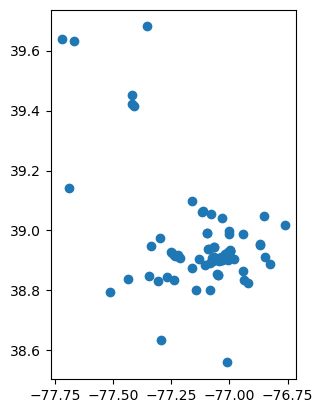

In [12]:

Join_higherInst.plot()

In [13]:
intp5, intp75 = overlay_wks(Join_higherInst)

In [14]:
intp5.loc[intp5['TOT_ENROLL'] < 0, 'TOT_ENROLL'] = np.nan
intp75.loc[intp75['TOT_ENROLL'] < 0, 'TOT_ENROLL'] = np.nan

In [15]:
intp5 = intp5[['Name_1', 'TOT_ENROLL']]
intp75 = intp75[['Name_1', 'TOT_ENROLL']]

In [16]:
intp5.groupby('Name_1')['TOT_ENROLL'].sum().reset_index().rename(columns={'TOT_ENROLL':'TOT_ENROLL_p5'}).to_csv('output/Enrollment_colleges_p5.csv', index=False)
intp75.groupby('Name_1')['TOT_ENROLL'].sum().reset_index().rename(columns={'TOT_ENROLL':'TOT_ENROLL_p75'}).to_csv('output/Enrollment_colleges_p75.csv', index=False)

### High School Preprocessing

In [17]:
highSchool = highSchool[['NMCNTY', 'SCH_NAME', 'geometry', 'TOTAL']]
highSchool['NMCNTY'] = highSchool['NMCNTY'].str.replace('County', '').str.strip()

In [18]:
highSchool.head()

,NMCNTY,SCH_NAME,geometry,TOTAL
0,Marshall,Albertville Middle School,POINT (-86.20620 34.26020),908.0
1,Marshall,Albertville High School,POINT (-86.20490 34.26220),1606.0
2,Marshall,Albertville Intermediate School,POINT (-86.22010 34.27330),891.0
3,Marshall,Albertville Elementary School,POINT (-86.22181 34.25270),908.0
4,Marshall,Albertville Kindergarten and PreK,POINT (-86.19330 34.28980),556.0


In [19]:
highSchool = counties.merge(highSchool, left_on='name', right_on='NMCNTY')

In [20]:
boundary = all_boundaries[['COUNTYFIPS20', 'NAME20', 'geometry']]

In [21]:
joinHighSchool = boundary.merge(highSchool, 
                                       left_on="COUNTYFIPS20", 
                                       right_on = "id", how='inner'
                                       )

In [22]:
joinHighSchool.drop(['geometry', 'NAME20', 'name','geometry_x'], axis=1, inplace=True)
joinHighSchool['geometry'] = joinHighSchool['geometry_y']

In [23]:
joinHighSchool = joinHighSchool.drop_duplicates(subset='SCH_NAME').reset_index(drop=True)

In [24]:
intersect_HS_p5, intersect_HS_p75 = overlay_wks(joinHighSchool)

In [25]:
intersect_HS_p5.loc[intersect_HS_p5['TOTAL']<0, 'TOTAL'] = np.nan
intersect_HS_p75.loc[intersect_HS_p75['TOTAL']<0, 'TOTAL'] = np.nan

In [26]:
intersect_HS_p5 = intersect_HS_p5[['Name_1', 'TOTAL']]
intersect_HS_p75 = intersect_HS_p75[['Name_1', 'TOTAL']]

In [27]:
intersect_HS_p5.groupby('Name_1').sum().reset_index().rename(columns={'TOTAL':'TOTAL_p5'}).to_csv('output/Enrollment_highschool_p5.csv', index=False)
intersect_HS_p75.groupby('Name_1').sum().reset_index().rename(columns={'TOTAL':'TOTAL_p75'}).to_csv('output/Enrollment_highschool_p75.csv', index=False)